In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8500.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '128.5457MHz', 'g13': '8.5381MHz', 'g23': '121.9492MHz'}


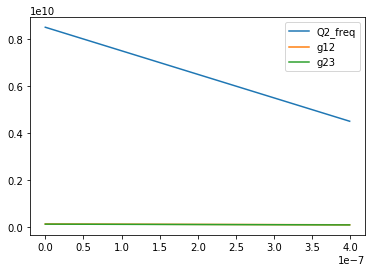

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.5e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

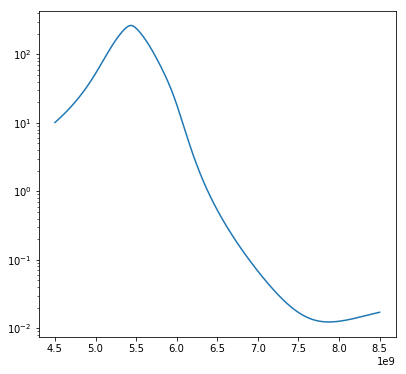

In [3]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [4]:
%matplotlib inline

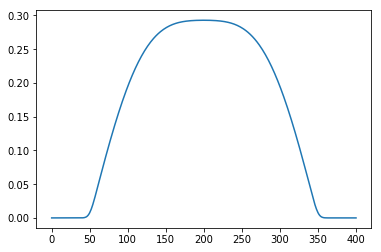

In [12]:
gate_time=30e-9
SRATE=10e9
total_len = gate_time + 10e-9
Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Fourier',t0=total_len/2,width=gate_time,plateau=0e-9,amplitude=0.3255,frequency=0,sine=True,F_Terms=2,Lcoeff=np.array([1,0.1]))
Seq.add_filter('Gauss Low Pass',300e6)
flux_pulse=Seq.get_sequence()

plt.plot(flux_pulse)

In [9]:
def cost_func(pulse_params,*args):
    gate_time,SRATE,terms=args

    Lcoeff = pulse_params
    total_len = gate_time + 10e-9

    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Fourier',t0=total_len/2,width=gate_time,plateau=0e-9,amplitude=1,frequency=0,sine=True,F_Terms=terms,Lcoeff=np.array(Lcoeff))
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
        

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

#     print('Lcoeff:',Lcoeff)
#     print('error:',1-fidelity)
    return 1 - fidelity



In [27]:
SRATE=10e9
gate_time_arr = np.arange(40e-9,30.9e-9,-1e-9)

gate_fidelity_cos1 = []
gate_params_cos1 = []
raw_initial_seeds=np.array([0.3245718 , 0.05218969, 0.01340684])
for gate_time in gate_time_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,3), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':50})

    gate_fidelity_cos1.append(DATA.fun)
    gate_params_cos1.append(DATA.x)
    raw_initial_seeds =DATA.x
    print('gate time',gate_time)
    print('fidelity',DATA.fun)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_params_three_new.txt',gate_params_cos1 )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_error_three_new.txt',gate_fidelity_cos1 )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_gate_three_new.txt',gate_time_arr )
   

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 24
         Function evaluations: 50
gate time 4e-08
fidelity 1.1052093709107425e-05
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 23
         Function evaluations: 47
gate time 3.9e-08
fidelity 3.294428103139957e-05
gate time 3.7999999999999996e-08
fidelity 2.1409766872593217e-05
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 24
         Function evaluations: 49
gate time 3.6999999999999994e-08
fidelity 6.33436051561409e-05
gate time 3.599999999999999e-08
fidelity 7.75024145196479e-05
gate time 3.499999999999999e-08
fidelity 0.00014201350726705808
gate time 3.399999999999999e-08
fidelity 0.0002650293798085457
Optimization terminated successfully.
         Current function value: 0.000474
         Iterations: 42
         Function evaluations: 79
gate time 3.2999999999999984e-08
f

In [18]:
Sine_Three_error = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_error_three.txt')
Sine_Three_time = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_gate_three.txt')
Sine_Three_param = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_params_three.txt')


In [24]:
Sine_Three_error[30]

1.8577271042596877e-06

In [25]:
Sine_Three_time[30]

4.200000000000002e-08

In [26]:
Sine_Three_param[30]

array([0.3245718 , 0.05218969, 0.01340684])

In [17]:
SRATE=10e9
gate_time_arr = np.arange(60e-9,11.9e-9,-1e-9)

gate_fidelity_cos1 = []
gate_params_cos1 = []
raw_initial_seeds=np.array([0.12, -0.02,0.01])
for gate_time in gate_time_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,3), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':50})

    gate_fidelity_cos1.append(DATA.fun)
    gate_params_cos1.append(DATA.x)
    raw_initial_seeds =DATA.x
    print('gate time',gate_time)
    print('fidelity',DATA.fun)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_params_three_inverse.txt',gate_params_cos1 )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_error_three_inverse.txt',gate_fidelity_cos1 )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\fourier_pulse\Sine_gate_three_inverse.txt',gate_time_arr )
   

Optimization terminated successfully.
         Current function value: 0.000495
         Iterations: 36
         Function evaluations: 73
gate time 6e-08
fidelity 0.0004954406874646544
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 43
         Function evaluations: 88
gate time 5.899999999999999e-08
fidelity 6.271913118027772e-05
Optimization terminated successfully.
         Current function value: 0.000073
         Iterations: 19
         Function evaluations: 40
gate time 5.799999999999999e-08
fidelity 7.327966559889099e-05
Optimization terminated successfully.
         Current function value: 0.000094
         Iterations: 17
         Function evaluations: 36
gate time 5.699999999999999e-08
fidelity 9.421412292631715e-05
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 18
         Function evaluations: 38
gate time 5.5999999999999985e-08
fidelity 0.00013107408157686518
Optimizat

Optimization terminated successfully.
         Current function value: 0.128056
         Iterations: 24
         Function evaluations: 47
gate time 1.6999999999999894e-08
fidelity 0.1280557268025444
Optimization terminated successfully.
         Current function value: 0.193436
         Iterations: 26
         Function evaluations: 49
gate time 1.5999999999999892e-08
fidelity 0.19343628702662274
Optimization terminated successfully.
         Current function value: 0.261466
         Iterations: 30
         Function evaluations: 59
gate time 1.499999999999989e-08
fidelity 0.2614657797720843
Optimization terminated successfully.
         Current function value: 0.274448
         Iterations: 25
         Function evaluations: 48
gate time 1.3999999999999887e-08
fidelity 0.27444797260994636
Optimization terminated successfully.
         Current function value: 0.083159
         Iterations: 38
         Function evaluations: 75
gate time 1.2999999999999885e-08
fidelity 0.08315943740546616
Opt

In [11]:
# gate_params_cos1[10:]

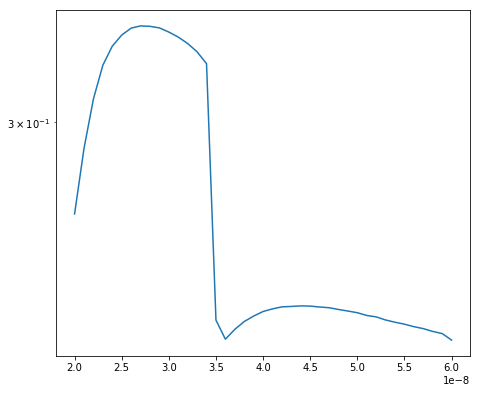

In [102]:
fig = plt.figure(figsize=[8,6.4])
ax = fig.add_axes([0.15,0.15,0.72,0.75])
ax.plot(gate_time_arr,np.array(gate_params_cos1)[:,0])
ax.set_yscale('log')

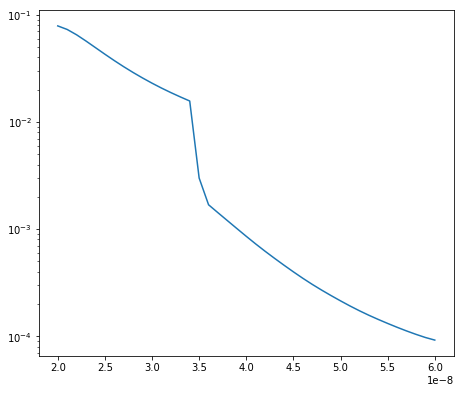

In [94]:
fig = plt.figure(figsize=[8,6.4])
ax = fig.add_axes([0.15,0.15,0.72,0.75])
ax.plot(gate_time_arr,gate_fidelity_cos1)
ax.set_yscale('log')

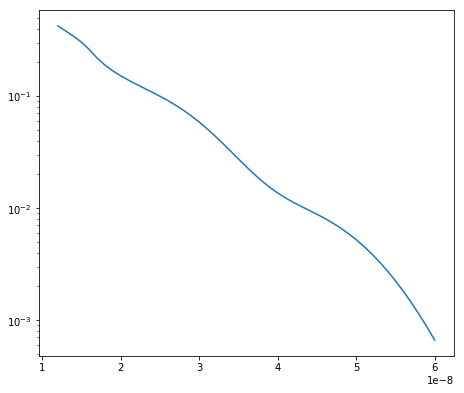

In [44]:
fig = plt.figure(figsize=[8,6.4])
ax = fig.add_axes([0.15,0.15,0.72,0.75])
ax.plot(gate_time_arr,gate_fidelity_cos1)

ax.set_yscale('log')

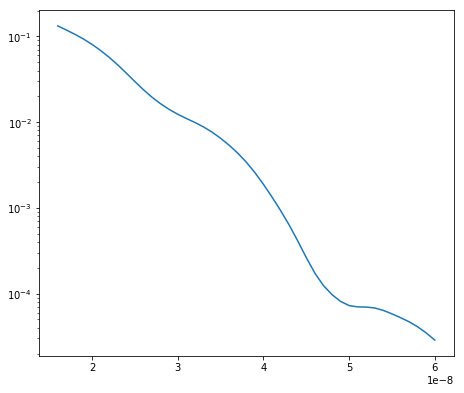

In [26]:
fig = plt.figure(figsize=[8,6.4])
ax = fig.add_axes([0.15,0.15,0.72,0.75])
ax.plot(gate_time_arr,gate_fidelity_cos)

ax.set_yscale('log')